In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


## Importing Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from itertools import product
from datetime import timedelta

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Loading Dataset

In [4]:
df = pd.read_csv('../DataFrames/final_merged_copper_dataset.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df

,Date,Price,Month,Year,Real_GDP,CPI,inflation_rate,PALLFNFINDEXM,DEXCHUS
0,2000-01-04,0.8480,1.0,2000.0,14096.033,168.8,3.376857,59.470000,0.120774
1,2000-01-05,0.8565,1.0,2000.0,14096.033,168.8,3.376857,59.470000,0.120776
2,2000-01-06,0.8530,1.0,2000.0,14096.033,168.8,3.376857,59.470000,0.120777
3,2000-01-07,0.8540,1.0,2000.0,14096.033,168.8,3.376857,59.470000,0.120782
4,2000-01-10,0.8465,1.0,2000.0,14096.033,168.8,3.376857,59.470000,0.120782
...,...,...,...,...,...,...,...,...,...
6047,2023-11-20,3.8335,11.0,2023.0,19374.000,307.0,6.600000,168.657489,0.139509
6048,2023-11-21,3.8395,11.0,2023.0,19374.000,307.0,6.600000,168.657489,0.140150
6049,2023-11-22,3.7970,11.0,2023.0,19374.000,307.0,6.600000,168.657489,0.139762
6050,2023-11-23,3.7743,11.0,2023.0,19374.000,307.0,6.600000,168.657489,0.139823


In [5]:
last_date = df['Date'].max().date()
last_date

datetime.date(2023, 11, 24)

In [6]:
df

,Date,Price,Month,Year,Real_GDP,CPI,inflation_rate,PALLFNFINDEXM,DEXCHUS
0,2000-01-04,0.8480,1.0,2000.0,14096.033,168.8,3.376857,59.470000,0.120774
1,2000-01-05,0.8565,1.0,2000.0,14096.033,168.8,3.376857,59.470000,0.120776
2,2000-01-06,0.8530,1.0,2000.0,14096.033,168.8,3.376857,59.470000,0.120777
3,2000-01-07,0.8540,1.0,2000.0,14096.033,168.8,3.376857,59.470000,0.120782
4,2000-01-10,0.8465,1.0,2000.0,14096.033,168.8,3.376857,59.470000,0.120782
...,...,...,...,...,...,...,...,...,...
6047,2023-11-20,3.8335,11.0,2023.0,19374.000,307.0,6.600000,168.657489,0.139509
6048,2023-11-21,3.8395,11.0,2023.0,19374.000,307.0,6.600000,168.657489,0.140150
6049,2023-11-22,3.7970,11.0,2023.0,19374.000,307.0,6.600000,168.657489,0.139762
6050,2023-11-23,3.7743,11.0,2023.0,19374.000,307.0,6.600000,168.657489,0.139823


In [7]:
LOOKBACK = 15
data = pd.DataFrame({'Date': df["Date"].copy(),
                     'Price': df["Price"].copy()})
# Select the "Date" column and store it in the variable 'train_dates'.
dates = data["Date"]

# Exclude the first 'LOOKBACK' dates from 'train_dates' to create a time window.
dates = dates[LOOKBACK:]
dates

15     2000-01-26
16     2000-01-27
17     2000-01-28
18     2000-01-31
19     2000-02-01
          ...    
6047   2023-11-20
6048   2023-11-21
6049   2023-11-22
6050   2023-11-23
6051   2023-11-24
Name: Date, Length: 6037, dtype: datetime64[ns]

In [8]:
data

,Date,Price
0,2000-01-04,0.8480
1,2000-01-05,0.8565
2,2000-01-06,0.8530
3,2000-01-07,0.8540
4,2000-01-10,0.8465
...,...,...
6047,2023-11-20,3.8335
6048,2023-11-21,3.8395
6049,2023-11-22,3.7970
6050,2023-11-23,3.7743


In [9]:
dates.reset_index(drop=True, inplace=True)

In [10]:
dates

0      2000-01-26
1      2000-01-27
2      2000-01-28
3      2000-01-31
4      2000-02-01
          ...    
6032   2023-11-20
6033   2023-11-21
6034   2023-11-22
6035   2023-11-23
6036   2023-11-24
Name: Date, Length: 6037, dtype: datetime64[ns]

In [11]:
from copy import deepcopy as dc


def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    #df.set_index('Date', inplace=True)

    for i in range(1, n_steps + 1):
        df[f'Price(t-{i})'] = df['Price'].shift(i)

    df.dropna(inplace=True)

    return df


shifted_df = prepare_dataframe_for_lstm(data, LOOKBACK)
shifted_df = shifted_df.reset_index(drop=True)
df = df.drop(df.index[-LOOKBACK:])
df

,Date,Price,Month,Year,Real_GDP,CPI,inflation_rate,PALLFNFINDEXM,DEXCHUS
0,2000-01-04,0.8480,1.0,2000.0,14096.033,168.8,3.376857,59.470000,0.120774
1,2000-01-05,0.8565,1.0,2000.0,14096.033,168.8,3.376857,59.470000,0.120776
2,2000-01-06,0.8530,1.0,2000.0,14096.033,168.8,3.376857,59.470000,0.120777
3,2000-01-07,0.8540,1.0,2000.0,14096.033,168.8,3.376857,59.470000,0.120782
4,2000-01-10,0.8465,1.0,2000.0,14096.033,168.8,3.376857,59.470000,0.120782
...,...,...,...,...,...,...,...,...,...
6032,2023-10-30,3.6585,10.0,2023.0,19374.000,307.0,6.600000,168.657489,0.136737
6033,2023-10-31,3.6490,10.0,2023.0,19374.000,307.0,6.600000,168.657489,0.136676
6034,2023-11-01,3.6490,11.0,2023.0,19374.000,307.0,6.600000,168.657489,0.136659
6035,2023-11-02,3.6725,11.0,2023.0,19374.000,307.0,6.600000,168.657489,0.136687


In [12]:
shifted_df

,Date,Price,Price(t-1),Price(t-2),Price(t-3),Price(t-4),Price(t-5),Price(t-6),Price(t-7),Price(t-8),Price(t-9),Price(t-10),Price(t-11),Price(t-12),Price(t-13),Price(t-14),Price(t-15)
0,2000-01-26,0.8415,0.8425,0.8565,0.8730,0.8730,0.8825,0.8660,0.8625,0.8565,0.8660,0.8435,0.8465,0.8540,0.8530,0.8565,0.8480
1,2000-01-27,0.8445,0.8415,0.8425,0.8565,0.8730,0.8730,0.8825,0.8660,0.8625,0.8565,0.8660,0.8435,0.8465,0.8540,0.8530,0.8565
2,2000-01-28,0.8400,0.8445,0.8415,0.8425,0.8565,0.8730,0.8730,0.8825,0.8660,0.8625,0.8565,0.8660,0.8435,0.8465,0.8540,0.8530
3,2000-01-31,0.8545,0.8400,0.8445,0.8415,0.8425,0.8565,0.8730,0.8730,0.8825,0.8660,0.8625,0.8565,0.8660,0.8435,0.8465,0.8540
4,2000-02-01,0.8480,0.8545,0.8400,0.8445,0.8415,0.8425,0.8565,0.8730,0.8730,0.8825,0.8660,0.8625,0.8565,0.8660,0.8435,0.8465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6032,2023-11-20,3.8335,3.7345,3.7025,3.7185,3.6835,3.6660,3.5870,3.6405,3.6380,3.6790,3.7190,3.6815,3.6725,3.6490,3.6490,3.6585
6033,2023-11-21,3.8395,3.8335,3.7345,3.7025,3.7185,3.6835,3.6660,3.5870,3.6405,3.6380,3.6790,3.7190,3.6815,3.6725,3.6490,3.6490
6034,2023-11-22,3.7970,3.8395,3.8335,3.7345,3.7025,3.7185,3.6835,3.6660,3.5870,3.6405,3.6380,3.6790,3.7190,3.6815,3.6725,3.6490
6035,2023-11-23,3.7743,3.7970,3.8395,3.8335,3.7345,3.7025,3.7185,3.6835,3.6660,3.5870,3.6405,3.6380,3.6790,3.7190,3.6815,3.6725


In [13]:
shifted_df["Real_GDP"] = df["Real_GDP"]
shifted_df["CPI"] = df["CPI"]
shifted_df["inflation_rate"] = df["inflation_rate"]
shifted_df["PALLFNFINDEXM"] = df["PALLFNFINDEXM"]
shifted_df["DEXCHUS"] = df["DEXCHUS"]
shifted_df

,Date,Price,Price(t-1),Price(t-2),Price(t-3),Price(t-4),Price(t-5),Price(t-6),Price(t-7),Price(t-8),...,Price(t-11),Price(t-12),Price(t-13),Price(t-14),Price(t-15),Real_GDP,CPI,inflation_rate,PALLFNFINDEXM,DEXCHUS
0,2000-01-26,0.8415,0.8425,0.8565,0.8730,0.8730,0.8825,0.8660,0.8625,0.8565,...,0.8465,0.8540,0.8530,0.8565,0.8480,14096.033,168.8,3.376857,59.470000,0.120774
1,2000-01-27,0.8445,0.8415,0.8425,0.8565,0.8730,0.8730,0.8825,0.8660,0.8625,...,0.8435,0.8465,0.8540,0.8530,0.8565,14096.033,168.8,3.376857,59.470000,0.120776
2,2000-01-28,0.8400,0.8445,0.8415,0.8425,0.8565,0.8730,0.8730,0.8825,0.8660,...,0.8660,0.8435,0.8465,0.8540,0.8530,14096.033,168.8,3.376857,59.470000,0.120777
3,2000-01-31,0.8545,0.8400,0.8445,0.8415,0.8425,0.8565,0.8730,0.8730,0.8825,...,0.8565,0.8660,0.8435,0.8465,0.8540,14096.033,168.8,3.376857,59.470000,0.120782
4,2000-02-01,0.8480,0.8545,0.8400,0.8445,0.8415,0.8425,0.8565,0.8730,0.8730,...,0.8625,0.8565,0.8660,0.8435,0.8465,14096.033,168.8,3.376857,59.470000,0.120782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6032,2023-11-20,3.8335,3.7345,3.7025,3.7185,3.6835,3.6660,3.5870,3.6405,3.6380,...,3.6815,3.6725,3.6490,3.6490,3.6585,19374.000,307.0,6.600000,168.657489,0.136737
6033,2023-11-21,3.8395,3.8335,3.7345,3.7025,3.7185,3.6835,3.6660,3.5870,3.6405,...,3.7190,3.6815,3.6725,3.6490,3.6490,19374.000,307.0,6.600000,168.657489,0.136676
6034,2023-11-22,3.7970,3.8395,3.8335,3.7345,3.7025,3.7185,3.6835,3.6660,3.5870,...,3.6790,3.7190,3.6815,3.6725,3.6490,19374.000,307.0,6.600000,168.657489,0.136659
6035,2023-11-23,3.7743,3.7970,3.8395,3.8335,3.7345,3.7025,3.7185,3.6835,3.6660,...,3.6380,3.6790,3.7190,3.6815,3.6725,19374.000,307.0,6.600000,168.657489,0.136687


In [14]:
price_columns = [col for col in shifted_df.columns if 'Price' in col]
price_columns

['Price',
 'Price(t-1)',
 'Price(t-2)',
 'Price(t-3)',
 'Price(t-4)',
 'Price(t-5)',
 'Price(t-6)',
 'Price(t-7)',
 'Price(t-8)',
 'Price(t-9)',
 'Price(t-10)',
 'Price(t-11)',
 'Price(t-12)',
 'Price(t-13)',
 'Price(t-14)',
 'Price(t-15)']

## Scaling Data

In [15]:
prices_before_scaling_as_np = shifted_df[price_columns].values
prices_before_scaling_as_np

array([[0.8415, 0.8425, 0.8565, ..., 0.853 , 0.8565, 0.848 ],
       [0.8445, 0.8415, 0.8425, ..., 0.854 , 0.853 , 0.8565],
       [0.84  , 0.8445, 0.8415, ..., 0.8465, 0.854 , 0.853 ],
       ...,
       [3.797 , 3.8395, 3.8335, ..., 3.6815, 3.6725, 3.649 ],
       [3.7743, 3.797 , 3.8395, ..., 3.719 , 3.6815, 3.6725],
       [3.8205, 3.7743, 3.797 , ..., 3.679 , 3.719 , 3.6815]])

In [16]:
prices_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_prices = prices_scaler.fit_transform(prices_before_scaling_as_np)
scaled_prices

array([[-0.89235389, -0.89189189, -0.88542389, ..., -0.88704089,
        -0.88542389, -0.88935089],
       [-0.89096789, -0.89235389, -0.89189189, ..., -0.88657889,
        -0.88704089, -0.88542389],
       [-0.89304689, -0.89096789, -0.89235389, ..., -0.89004389,
        -0.88657889, -0.88704089],
       ...,
       [ 0.47308847,  0.49272349,  0.48995149, ...,  0.41972742,
         0.41556942,  0.4047124 ],
       [ 0.46260106,  0.47308847,  0.49272349, ...,  0.43705244,
         0.41972742,  0.41556942],
       [ 0.48394548,  0.46260106,  0.47308847, ...,  0.41857242,
         0.43705244,  0.41972742]])

In [17]:
scaled_prices.shape

(6037, 16)

In [18]:
GDP_before_scaling_as_np = shifted_df["Real_GDP"].to_numpy()
CPI_before_scaling_as_np = shifted_df["CPI"].to_numpy()
inflation_rate_before_scaling_as_np = shifted_df["inflation_rate"].to_numpy()
PALLFNFINDEXM_before_scaling_as_np = shifted_df["PALLFNFINDEXM"].to_numpy()
DEXCHUS = shifted_df["DEXCHUS"].to_numpy()

In [19]:
GDP_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_GDP = GDP_scaler.fit_transform(GDP_before_scaling_as_np.reshape(-1, 1))
scaled_GDP

array([[-1.        ],
       [-1.        ],
       [-1.        ],
       ...,
       [ 0.36628638],
       [ 0.36628638],
       [ 0.36628638]])

In [20]:
CPI_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_CPI = CPI_scaler.fit_transform(CPI_before_scaling_as_np.reshape(-1, 1))
scaled_CPI

array([[-1.        ],
       [-1.        ],
       [-1.        ],
       ...,
       [ 0.98864658],
       [ 0.98864658],
       [ 0.98864658]])

In [21]:
IR_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_IR = IR_scaler.fit_transform(inflation_rate_before_scaling_as_np.reshape(-1, 1))
scaled_IR

array([[-0.10690381],
       [-0.10690381],
       [-0.10690381],
       ...,
       [ 0.66433555],
       [ 0.66433555],
       [ 0.66433555]])

In [22]:
PALLFNFINDEXM_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_PALLFNFINDEXM = PALLFNFINDEXM_scaler.fit_transform(PALLFNFINDEXM_before_scaling_as_np.reshape(-1, 1))
scaled_PALLFNFINDEXM

array([[-0.88354852],
       [-0.88354852],
       [-0.88354852],
       ...,
       [ 0.24367179],
       [ 0.24367179],
       [ 0.24367179]])

In [23]:
DEXCHUS_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_DEXCHUS = DEXCHUS_scaler.fit_transform(DEXCHUS.reshape(-1, 1))
scaled_DEXCHUS

array([[-0.99993486],
       [-0.99986972],
       [-0.99980458],
       ...,
       [-0.29056913],
       [-0.28931784],
       [-0.27635776]])

In [24]:

stacked_np = np.hstack((scaled_prices, scaled_GDP,scaled_CPI,scaled_IR,scaled_PALLFNFINDEXM,scaled_DEXCHUS))

# Display the combined NumPy array
stacked_np.shape


(6037, 21)

In [25]:
scaled_prices.shape

(6037, 16)

In [26]:
scaled_df = shifted_df.drop(['Date'], axis=1)
scaled_df

,Price,Price(t-1),Price(t-2),Price(t-3),Price(t-4),Price(t-5),Price(t-6),Price(t-7),Price(t-8),Price(t-9),...,Price(t-11),Price(t-12),Price(t-13),Price(t-14),Price(t-15),Real_GDP,CPI,inflation_rate,PALLFNFINDEXM,DEXCHUS
0,0.8415,0.8425,0.8565,0.8730,0.8730,0.8825,0.8660,0.8625,0.8565,0.8660,...,0.8465,0.8540,0.8530,0.8565,0.8480,14096.033,168.8,3.376857,59.470000,0.120774
1,0.8445,0.8415,0.8425,0.8565,0.8730,0.8730,0.8825,0.8660,0.8625,0.8565,...,0.8435,0.8465,0.8540,0.8530,0.8565,14096.033,168.8,3.376857,59.470000,0.120776
2,0.8400,0.8445,0.8415,0.8425,0.8565,0.8730,0.8730,0.8825,0.8660,0.8625,...,0.8660,0.8435,0.8465,0.8540,0.8530,14096.033,168.8,3.376857,59.470000,0.120777
3,0.8545,0.8400,0.8445,0.8415,0.8425,0.8565,0.8730,0.8730,0.8825,0.8660,...,0.8565,0.8660,0.8435,0.8465,0.8540,14096.033,168.8,3.376857,59.470000,0.120782
4,0.8480,0.8545,0.8400,0.8445,0.8415,0.8425,0.8565,0.8730,0.8730,0.8825,...,0.8625,0.8565,0.8660,0.8435,0.8465,14096.033,168.8,3.376857,59.470000,0.120782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6032,3.8335,3.7345,3.7025,3.7185,3.6835,3.6660,3.5870,3.6405,3.6380,3.6790,...,3.6815,3.6725,3.6490,3.6490,3.6585,19374.000,307.0,6.600000,168.657489,0.136737
6033,3.8395,3.8335,3.7345,3.7025,3.7185,3.6835,3.6660,3.5870,3.6405,3.6380,...,3.7190,3.6815,3.6725,3.6490,3.6490,19374.000,307.0,6.600000,168.657489,0.136676
6034,3.7970,3.8395,3.8335,3.7345,3.7025,3.7185,3.6835,3.6660,3.5870,3.6405,...,3.6790,3.7190,3.6815,3.6725,3.6490,19374.000,307.0,6.600000,168.657489,0.136659
6035,3.7743,3.7970,3.8395,3.8335,3.7345,3.7025,3.7185,3.6835,3.6660,3.5870,...,3.6380,3.6790,3.7190,3.6815,3.6725,19374.000,307.0,6.600000,168.657489,0.136687


In [27]:
flipped_df = shifted_df[shifted_df.columns[::-1]]
flipped_df = flipped_df.drop(['Date'], axis=1)
flipped_df

,DEXCHUS,PALLFNFINDEXM,inflation_rate,CPI,Real_GDP,Price(t-15),Price(t-14),Price(t-13),Price(t-12),Price(t-11),...,Price(t-9),Price(t-8),Price(t-7),Price(t-6),Price(t-5),Price(t-4),Price(t-3),Price(t-2),Price(t-1),Price
0,0.120774,59.470000,3.376857,168.8,14096.033,0.8480,0.8565,0.8530,0.8540,0.8465,...,0.8660,0.8565,0.8625,0.8660,0.8825,0.8730,0.8730,0.8565,0.8425,0.8415
1,0.120776,59.470000,3.376857,168.8,14096.033,0.8565,0.8530,0.8540,0.8465,0.8435,...,0.8565,0.8625,0.8660,0.8825,0.8730,0.8730,0.8565,0.8425,0.8415,0.8445
2,0.120777,59.470000,3.376857,168.8,14096.033,0.8530,0.8540,0.8465,0.8435,0.8660,...,0.8625,0.8660,0.8825,0.8730,0.8730,0.8565,0.8425,0.8415,0.8445,0.8400
3,0.120782,59.470000,3.376857,168.8,14096.033,0.8540,0.8465,0.8435,0.8660,0.8565,...,0.8660,0.8825,0.8730,0.8730,0.8565,0.8425,0.8415,0.8445,0.8400,0.8545
4,0.120782,59.470000,3.376857,168.8,14096.033,0.8465,0.8435,0.8660,0.8565,0.8625,...,0.8825,0.8730,0.8730,0.8565,0.8425,0.8415,0.8445,0.8400,0.8545,0.8480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6032,0.136737,168.657489,6.600000,307.0,19374.000,3.6585,3.6490,3.6490,3.6725,3.6815,...,3.6790,3.6380,3.6405,3.5870,3.6660,3.6835,3.7185,3.7025,3.7345,3.8335
6033,0.136676,168.657489,6.600000,307.0,19374.000,3.6490,3.6490,3.6725,3.6815,3.7190,...,3.6380,3.6405,3.5870,3.6660,3.6835,3.7185,3.7025,3.7345,3.8335,3.8395
6034,0.136659,168.657489,6.600000,307.0,19374.000,3.6490,3.6725,3.6815,3.7190,3.6790,...,3.6405,3.5870,3.6660,3.6835,3.7185,3.7025,3.7345,3.8335,3.8395,3.7970
6035,0.136687,168.657489,6.600000,307.0,19374.000,3.6725,3.6815,3.7190,3.6790,3.6380,...,3.5870,3.6660,3.6835,3.7185,3.7025,3.7345,3.8335,3.8395,3.7970,3.7743


In [28]:
flipped_df.reset_index(drop=True, inplace=True)

In [29]:
df.drop(columns=['Price'], inplace=True)

In [30]:
new_df = pd.concat([df, flipped_df], axis=1)

In [31]:
new_df

,Date,Month,Year,Real_GDP,CPI,inflation_rate,PALLFNFINDEXM,DEXCHUS,DEXCHUS,PALLFNFINDEXM,...,Price(t-9),Price(t-8),Price(t-7),Price(t-6),Price(t-5),Price(t-4),Price(t-3),Price(t-2),Price(t-1),Price
0,2000-01-04,1.0,2000.0,14096.033,168.8,3.376857,59.470000,0.120774,0.120774,59.470000,...,0.8660,0.8565,0.8625,0.8660,0.8825,0.8730,0.8730,0.8565,0.8425,0.8415
1,2000-01-05,1.0,2000.0,14096.033,168.8,3.376857,59.470000,0.120776,0.120776,59.470000,...,0.8565,0.8625,0.8660,0.8825,0.8730,0.8730,0.8565,0.8425,0.8415,0.8445
2,2000-01-06,1.0,2000.0,14096.033,168.8,3.376857,59.470000,0.120777,0.120777,59.470000,...,0.8625,0.8660,0.8825,0.8730,0.8730,0.8565,0.8425,0.8415,0.8445,0.8400
3,2000-01-07,1.0,2000.0,14096.033,168.8,3.376857,59.470000,0.120782,0.120782,59.470000,...,0.8660,0.8825,0.8730,0.8730,0.8565,0.8425,0.8415,0.8445,0.8400,0.8545
4,2000-01-10,1.0,2000.0,14096.033,168.8,3.376857,59.470000,0.120782,0.120782,59.470000,...,0.8825,0.8730,0.8730,0.8565,0.8425,0.8415,0.8445,0.8400,0.8545,0.8480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6032,2023-10-30,10.0,2023.0,19374.000,307.0,6.600000,168.657489,0.136737,0.136737,168.657489,...,3.6790,3.6380,3.6405,3.5870,3.6660,3.6835,3.7185,3.7025,3.7345,3.8335
6033,2023-10-31,10.0,2023.0,19374.000,307.0,6.600000,168.657489,0.136676,0.136676,168.657489,...,3.6380,3.6405,3.5870,3.6660,3.6835,3.7185,3.7025,3.7345,3.8335,3.8395
6034,2023-11-01,11.0,2023.0,19374.000,307.0,6.600000,168.657489,0.136659,0.136659,168.657489,...,3.6405,3.5870,3.6660,3.6835,3.7185,3.7025,3.7345,3.8335,3.8395,3.7970
6035,2023-11-02,11.0,2023.0,19374.000,307.0,6.600000,168.657489,0.136687,0.136687,168.657489,...,3.5870,3.6660,3.6835,3.7185,3.7025,3.7345,3.8335,3.8395,3.7970,3.7743


In [32]:
new_df.drop(columns=['Month', 'Year'], inplace=True)
new_df

,Date,Real_GDP,CPI,inflation_rate,PALLFNFINDEXM,DEXCHUS,DEXCHUS,PALLFNFINDEXM,inflation_rate,CPI,...,Price(t-9),Price(t-8),Price(t-7),Price(t-6),Price(t-5),Price(t-4),Price(t-3),Price(t-2),Price(t-1),Price
0,2000-01-04,14096.033,168.8,3.376857,59.470000,0.120774,0.120774,59.470000,3.376857,168.8,...,0.8660,0.8565,0.8625,0.8660,0.8825,0.8730,0.8730,0.8565,0.8425,0.8415
1,2000-01-05,14096.033,168.8,3.376857,59.470000,0.120776,0.120776,59.470000,3.376857,168.8,...,0.8565,0.8625,0.8660,0.8825,0.8730,0.8730,0.8565,0.8425,0.8415,0.8445
2,2000-01-06,14096.033,168.8,3.376857,59.470000,0.120777,0.120777,59.470000,3.376857,168.8,...,0.8625,0.8660,0.8825,0.8730,0.8730,0.8565,0.8425,0.8415,0.8445,0.8400
3,2000-01-07,14096.033,168.8,3.376857,59.470000,0.120782,0.120782,59.470000,3.376857,168.8,...,0.8660,0.8825,0.8730,0.8730,0.8565,0.8425,0.8415,0.8445,0.8400,0.8545
4,2000-01-10,14096.033,168.8,3.376857,59.470000,0.120782,0.120782,59.470000,3.376857,168.8,...,0.8825,0.8730,0.8730,0.8565,0.8425,0.8415,0.8445,0.8400,0.8545,0.8480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6032,2023-10-30,19374.000,307.0,6.600000,168.657489,0.136737,0.136737,168.657489,6.600000,307.0,...,3.6790,3.6380,3.6405,3.5870,3.6660,3.6835,3.7185,3.7025,3.7345,3.8335
6033,2023-10-31,19374.000,307.0,6.600000,168.657489,0.136676,0.136676,168.657489,6.600000,307.0,...,3.6380,3.6405,3.5870,3.6660,3.6835,3.7185,3.7025,3.7345,3.8335,3.8395
6034,2023-11-01,19374.000,307.0,6.600000,168.657489,0.136659,0.136659,168.657489,6.600000,307.0,...,3.6405,3.5870,3.6660,3.6835,3.7185,3.7025,3.7345,3.8335,3.8395,3.7970
6035,2023-11-02,19374.000,307.0,6.600000,168.657489,0.136687,0.136687,168.657489,6.600000,307.0,...,3.5870,3.6660,3.6835,3.7185,3.7025,3.7345,3.8335,3.8395,3.7970,3.7743


In [33]:
flipped_df

,DEXCHUS,PALLFNFINDEXM,inflation_rate,CPI,Real_GDP,Price(t-15),Price(t-14),Price(t-13),Price(t-12),Price(t-11),...,Price(t-9),Price(t-8),Price(t-7),Price(t-6),Price(t-5),Price(t-4),Price(t-3),Price(t-2),Price(t-1),Price
0,0.120774,59.470000,3.376857,168.8,14096.033,0.8480,0.8565,0.8530,0.8540,0.8465,...,0.8660,0.8565,0.8625,0.8660,0.8825,0.8730,0.8730,0.8565,0.8425,0.8415
1,0.120776,59.470000,3.376857,168.8,14096.033,0.8565,0.8530,0.8540,0.8465,0.8435,...,0.8565,0.8625,0.8660,0.8825,0.8730,0.8730,0.8565,0.8425,0.8415,0.8445
2,0.120777,59.470000,3.376857,168.8,14096.033,0.8530,0.8540,0.8465,0.8435,0.8660,...,0.8625,0.8660,0.8825,0.8730,0.8730,0.8565,0.8425,0.8415,0.8445,0.8400
3,0.120782,59.470000,3.376857,168.8,14096.033,0.8540,0.8465,0.8435,0.8660,0.8565,...,0.8660,0.8825,0.8730,0.8730,0.8565,0.8425,0.8415,0.8445,0.8400,0.8545
4,0.120782,59.470000,3.376857,168.8,14096.033,0.8465,0.8435,0.8660,0.8565,0.8625,...,0.8825,0.8730,0.8730,0.8565,0.8425,0.8415,0.8445,0.8400,0.8545,0.8480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6032,0.136737,168.657489,6.600000,307.0,19374.000,3.6585,3.6490,3.6490,3.6725,3.6815,...,3.6790,3.6380,3.6405,3.5870,3.6660,3.6835,3.7185,3.7025,3.7345,3.8335
6033,0.136676,168.657489,6.600000,307.0,19374.000,3.6490,3.6490,3.6725,3.6815,3.7190,...,3.6380,3.6405,3.5870,3.6660,3.6835,3.7185,3.7025,3.7345,3.8335,3.8395
6034,0.136659,168.657489,6.600000,307.0,19374.000,3.6490,3.6725,3.6815,3.7190,3.6790,...,3.6405,3.5870,3.6660,3.6835,3.7185,3.7025,3.7345,3.8335,3.8395,3.7970
6035,0.136687,168.657489,6.600000,307.0,19374.000,3.6725,3.6815,3.7190,3.6790,3.6380,...,3.5870,3.6660,3.6835,3.7185,3.7025,3.7345,3.8335,3.8395,3.7970,3.7743


In [34]:
flipped_df_before_scaling_as_np = flipped_df.to_numpy()
flipped_df_before_scaling_as_np

array([[1.20774405e-01, 5.94700000e+01, 3.37685727e+00, ...,
        8.56500000e-01, 8.42500000e-01, 8.41500000e-01],
       [1.20775864e-01, 5.94700000e+01, 3.37685727e+00, ...,
        8.42500000e-01, 8.41500000e-01, 8.44500000e-01],
       [1.20777323e-01, 5.94700000e+01, 3.37685727e+00, ...,
        8.41500000e-01, 8.44500000e-01, 8.40000000e-01],
       ...,
       [1.36658695e-01, 1.68657489e+02, 6.60000000e+00, ...,
        3.83350000e+00, 3.83950000e+00, 3.79700000e+00],
       [1.36686714e-01, 1.68657489e+02, 6.60000000e+00, ...,
        3.83950000e+00, 3.79700000e+00, 3.77430000e+00],
       [1.36976919e-01, 1.68657489e+02, 6.60000000e+00, ...,
        3.79700000e+00, 3.77430000e+00, 3.82050000e+00]])

In [35]:
#price_scaler = MinMaxScaler(feature_range=(-1, 1))
#scaled_prices = price_scaler.fit_transform(flipped_df_before_scaling_as_np)

In [36]:
scaled_prices

array([[-0.89235389, -0.89189189, -0.88542389, ..., -0.88704089,
        -0.88542389, -0.88935089],
       [-0.89096789, -0.89235389, -0.89189189, ..., -0.88657889,
        -0.88704089, -0.88542389],
       [-0.89304689, -0.89096789, -0.89235389, ..., -0.89004389,
        -0.88657889, -0.88704089],
       ...,
       [ 0.47308847,  0.49272349,  0.48995149, ...,  0.41972742,
         0.41556942,  0.4047124 ],
       [ 0.46260106,  0.47308847,  0.49272349, ...,  0.43705244,
         0.41972742,  0.41556942],
       [ 0.48394548,  0.46260106,  0.47308847, ...,  0.41857242,
         0.43705244,  0.41972742]])

In [37]:
result = np.concatenate((scaled_GDP, scaled_CPI, scaled_IR, scaled_PALLFNFINDEXM,scaled_DEXCHUS, scaled_prices), axis=1)
result

array([[-1.        , -1.        , -0.10690381, ..., -0.88704089,
        -0.88542389, -0.88935089],
       [-1.        , -1.        , -0.10690381, ..., -0.88657889,
        -0.88704089, -0.88542389],
       [-1.        , -1.        , -0.10690381, ..., -0.89004389,
        -0.88657889, -0.88704089],
       ...,
       [ 0.36628638,  0.98864658,  0.66433555, ...,  0.41972742,
         0.41556942,  0.4047124 ],
       [ 0.36628638,  0.98864658,  0.66433555, ...,  0.43705244,
         0.41972742,  0.41556942],
       [ 0.36628638,  0.98864658,  0.66433555, ...,  0.41857242,
         0.43705244,  0.41972742]])

In [38]:
X = result[:, 0:LOOKBACK+4]
y = result[:, LOOKBACK+5]
X = X.astype(np.float32)
y = y.astype(np.float32)
X.shape

(6037, 19)

In [39]:
X

array([[-1.        , -1.        , -0.10690381, ..., -0.8900439 ,
        -0.88657886, -0.8870409 ],
       [-1.        , -1.        , -0.10690381, ..., -0.8914299 ,
        -0.8900439 , -0.88657886],
       [-1.        , -1.        , -0.10690381, ..., -0.8810349 ,
        -0.8914299 , -0.8900439 ],
       ...,
       [ 0.36628637,  0.98864657,  0.66433555, ...,  0.41857243,
         0.43705243,  0.4197274 ],
       [ 0.36628637,  0.98864657,  0.66433555, ...,  0.3996304 ,
         0.41857243,  0.43705243],
       [ 0.36628637,  0.98864657,  0.66433555, ...,  0.4007854 ,
         0.3996304 ,  0.41857243]], dtype=float32)

In [40]:

split_index = int(len(X) * 0.80)
split_date = dates[split_index]

X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]
train_dates = dates[:split_index]
test_dates = dates[split_index:]
train_dates

0      2000-01-26
1      2000-01-27
2      2000-01-28
3      2000-01-31
4      2000-02-01
          ...    
4824   2019-03-29
4825   2019-04-01
4826   2019-04-02
4827   2019-04-03
4828   2019-04-04
Name: Date, Length: 4829, dtype: datetime64[ns]

In [41]:
X_train.shape

(4829, 19)

## Prepare Dataset

In [44]:
X = X.reshape((-1, LOOKBACK+4, 1))
X_train = X_train.reshape((-1, LOOKBACK+4, 1))
X_test = X_test.reshape((-1, LOOKBACK+4, 1))

y = y.reshape((-1, 1))
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4829, 19, 1), (1208, 19, 1), (4829, 1), (1208, 1))

In [45]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_test.dtype

torch.float32

In [46]:
y_train.shape

torch.Size([4829, 1])

In [47]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

## LSTM Model

In [48]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [49]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([8, 19, 1]) torch.Size([8, 1])


In [50]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 12, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 12, batch_first=True)
  (fc): Linear(in_features=12, out_features=1, bias=True)
)

In [51]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.5f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [52]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.5f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [53]:
learning_rate = 0.001
num_epochs = 30
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Adam does the gradient descent

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.25501
Batch 200, Loss: 0.00841
Batch 300, Loss: 0.00454
Batch 400, Loss: 0.00342
Batch 500, Loss: 0.00257
Batch 600, Loss: 0.00217

Val Loss: 0.00465
***************************************************

Epoch: 2
Batch 100, Loss: 0.00154
Batch 200, Loss: 0.00151
Batch 300, Loss: 0.00149
Batch 400, Loss: 0.00144
Batch 500, Loss: 0.00125
Batch 600, Loss: 0.00161

Val Loss: 0.00205
***************************************************

Epoch: 3
Batch 100, Loss: 0.00146
Batch 200, Loss: 0.00129
Batch 300, Loss: 0.00127
Batch 400, Loss: 0.00128
Batch 500, Loss: 0.00128
Batch 600, Loss: 0.00134

Val Loss: 0.00172
***************************************************

Epoch: 4
Batch 100, Loss: 0.00143
Batch 200, Loss: 0.00120
Batch 300, Loss: 0.00115
Batch 400, Loss: 0.00116
Batch 500, Loss: 0.00124
Batch 600, Loss: 0.00112

Val Loss: 0.00163
***************************************************

Epoch: 5
Batch 100, Loss: 0.00120
Batch 200, Loss: 0.00120
Batch 300, Loss: 

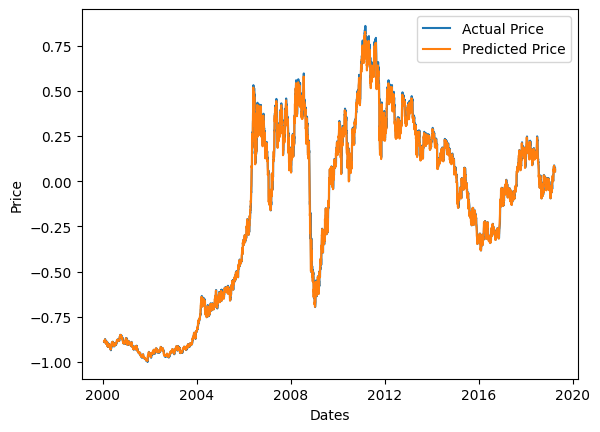

In [54]:
with torch.no_grad():
    predicted = model(X_train[:].to(device)).to('cpu').numpy()

plt.plot(train_dates, y_train, label='Actual Price')
plt.plot(train_dates, predicted, label='Predicted Price')

plt.xlabel('Dates')
plt.ylabel('Price')
plt.legend()
plt.show()


# Invert scaled predictions

In [ ]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], LOOKBACK+1))
dummies[:, 0] = train_predictions 
print(dummies[0])
dummies = prices_scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

In [ ]:
dummies = np.zeros((X_train.shape[0], LOOKBACK+1))
dummies[:, 0] = y_train.flatten()
dummies = prices_scaler.inverse_transform(dummies)
new_y_train = dc(dummies[:, 0])
new_y_train

## Plot Predictions vs Actual

In [ ]:
plt.plot(train_dates,new_y_train,  label='Actual Price')
plt.plot(train_dates,train_predictions, label='Predicted Price')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], LOOKBACK+1))
dummies[:, 0] = test_predictions
dummies = prices_scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

## Measure RMSE and MAE

In [ ]:
dummies = np.zeros((X_test.shape[0], LOOKBACK+1))
dummies[:, 0] = y_test.flatten()
dummies = prices_scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test
squared_differences = (new_y_test - test_predictions)**2

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean(squared_differences))
#rmse
absolute_differences = np.abs(new_y_test - test_predictions)

# Calculate the Mean Absolute Error (MAE)
mae = np.mean(absolute_differences)
rmse

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_dates, new_y_test, label='Actual Price')
plt.plot(test_dates, test_predictions, label='Predicted Price')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()

# Saving the figure as a JPG file
plt.savefig('../Visuals/price_prediction_plot.jpg', dpi=300, bbox_inches='tight')  # Adjust the filename and DPI as needed
plt.show()